In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from Billy.forecastingNN import WindowGenerator
import IPython
import IPython.display

In [2]:
#estos son los dias que han sido festivos en españa en 2021, 2022 y 2023 en Madrid 
festivos = ['2021-01-01', '2021-01-06', '2021-03-19','2021-04-01', '2021-04-02',  '2021-05-01', '2021-05-03', '2021-05-15', '2021-10-12', '2021-11-01', '2021-11-09','2021-12-06', '2021-12-08', '2021-12-25', 
            '2022-01-01', '2022-01-06', '2022-04-14', '2022-05-16', '2022-05-02', '2022-07-25','2022-08-15', '2022-10-12', '2022-11-01', '2022-11-09', '2022-12-06', '2022-12-08', '2022-12-26', 
            '2023-01-06', '2023-03-20']

#Barcelona
festivos2 = ['2021-01-01', '2021-01-06', '2021-04-02', '2021-04-05',  '2021-05-01',  '2021-05-24',  '2021-06-24',  '2021-09-11', '2021-09-24', '2021-10-12', '2021-11-01','2021-12-06', '2021-12-08', '2021-12-25',
             '2022-01-01', '2022-01-06', '2022-04-15', '2022-04-18', '2022-06-06', '2022-06-24','2022-08-15',  '2022-09-24', '2022-09-26', '2022-10-12', '2022-11-01', '2022-12-06', '2022-12-08', '2022-12-26',
             '2023-01-06']


festivos = pd.to_datetime(festivos)
festivos2 = pd.to_datetime(festivos2)

#estos fueron los dias que se tuvieron 0 visitantes Ikea en Madrid porque todos los ikeas estuvieron cerrados
cerom = ['2023-01-06']

#estos fueron los dias que se tuvieron 0 visitantes Ikea en Barcelona porque todos los ikeas estuvieron cerrados

cerob = ['2022-12-25', '2022-11-06', '2022-10-16', '2022-10-02', '2022-07-24', '2022-07-17', '2022-07-10', '2022-07-03', '2022-06-24', '2022-06-05', '2022-05-29', 
            '2022-05-15', '2022-05-08', '2022-05-01', '2022-04-18', '2022-04-17', '2022-02-27', '2022-01-30', '2021-12-25', '2021-10-24', '2021-10-17', '2021-10-03', 
            '2021-09-19', '2021-09-11', '2021-08-29', '2021-07-25', '2021-07-11', '2021-06-20', '2021-06-06', '2021-05-30', '2021-05-23', '2021-05-16', '2021-05-09', '2021-05-01']

cerom = pd.to_datetime(cerom)
cerob = pd.to_datetime(cerob)



In [3]:
df = pd.read_csv('../data/visits_train.csv', parse_dates=['date_visit'], dayfirst=True)
df['day_of_week'] = df['date_visit'].dt.dayofweek
df['festivo'] = 0
df['cerrado'] = 0

for location, festivos_loc in [('Madrid', festivos), ('Barcelona', festivos2)]:
    for festivo in festivos_loc:
        df.loc[df['date_visit'] == festivo, 'festivo'] = 1
for location, cero_loc in [('Madrid', cerom), ('Barcelona', cerob)]:
    for cerrado in cero_loc:
        df.loc[df['date_visit'] == cerrado, 'cerrado'] = 1
catCols = ['location', 'day_of_week', 'festivo', 'cerrado']
df.loc[:, catCols] = df.loc[:, catCols].astype('category')
        
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   location     1338 non-null   object        
 1   date_visit   1338 non-null   datetime64[ns]
 2   visits       1338 non-null   float64       
 3   day_of_week  1338 non-null   category      
 4   festivo      1338 non-null   category      
 5   cerrado      1338 non-null   category      
dtypes: category(3), datetime64[ns](1), float64(1), object(1)
memory usage: 35.9+ KB


In [4]:
date_time = pd.to_datetime(df.pop('date_visit'))

timestamp_s = date_time.map(pd.Timestamp.timestamp)

week = 7
year = 365

df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Wek cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   location     1338 non-null   object  
 1   visits       1338 non-null   float64 
 2   day_of_week  1338 non-null   category
 3   festivo      1338 non-null   category
 4   cerrado      1338 non-null   category
 5   Week sin     1338 non-null   float64 
 6   Wek cos      1338 non-null   float64 
 7   Year sin     1338 non-null   float64 
 8   Year cos     1338 non-null   float64 
dtypes: category(3), float64(5), object(1)
memory usage: 67.3+ KB


In [6]:
from sklearn.compose import make_column_transformer
transformer = make_column_transformer(
    (OneHotEncoder(), catCols),
    remainder='passthrough')

transformed = transformer.fit_transform(df)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())


In [7]:
column_indices = {name: i for i, name in enumerate(transformed_df.columns)}

n = len(transformed_df)
train_df = transformed_df[0:int(n*0.7)]
val_df = transformed_df[int(n*0.7):int(n*0.9)]
test_df = transformed_df[int(n*0.9):]
num_features = df.shape[1]


train_df

,onehotencoder__location_Barcelona,onehotencoder__location_Madrid,onehotencoder__day_of_week_0,onehotencoder__day_of_week_1,onehotencoder__day_of_week_2,onehotencoder__day_of_week_3,onehotencoder__day_of_week_4,onehotencoder__day_of_week_5,onehotencoder__day_of_week_6,onehotencoder__festivo_0,onehotencoder__festivo_1,onehotencoder__cerrado_0,onehotencoder__cerrado_1,remainder__visits,remainder__Week sin,remainder__Wek cos,remainder__Year sin,remainder__Year cos
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,67.323720,9.749279e-01,-0.222521,-0.455907,-0.890028
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,71.894430,4.338838e-01,-0.900969,-0.758306,0.651899
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,87.803810,-4.338836e-01,-0.900969,0.811539,0.584298
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,90.435243,-9.749279e-01,-0.222521,0.377708,-0.925925
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,76.281122,-7.818315e-01,0.623490,-0.988678,-0.150055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,67.670468,-9.749279e-01,-0.222521,-0.337523,0.941317
932,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,51.948570,-7.818315e-01,0.623490,0.994218,0.107381
933,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,52.922912,-3.652219e-08,1.000000,-0.128748,-0.991677
934,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,53.182342,7.818314e-01,0.623490,-0.933837,0.357698


In [8]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width = 7, label_width = OUT_STEPS, shift = OUT_STEPS, train_df= train_df, test_df=test_df, val_df=val_df)
multi_window

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None

In [9]:
example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[100:100+multi_window.total_window_size]),
                           np.array(train_df[200:200+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 14, 18)
Inputs shape: (3, 7, 18)
Labels shape: (3, 7, 18)


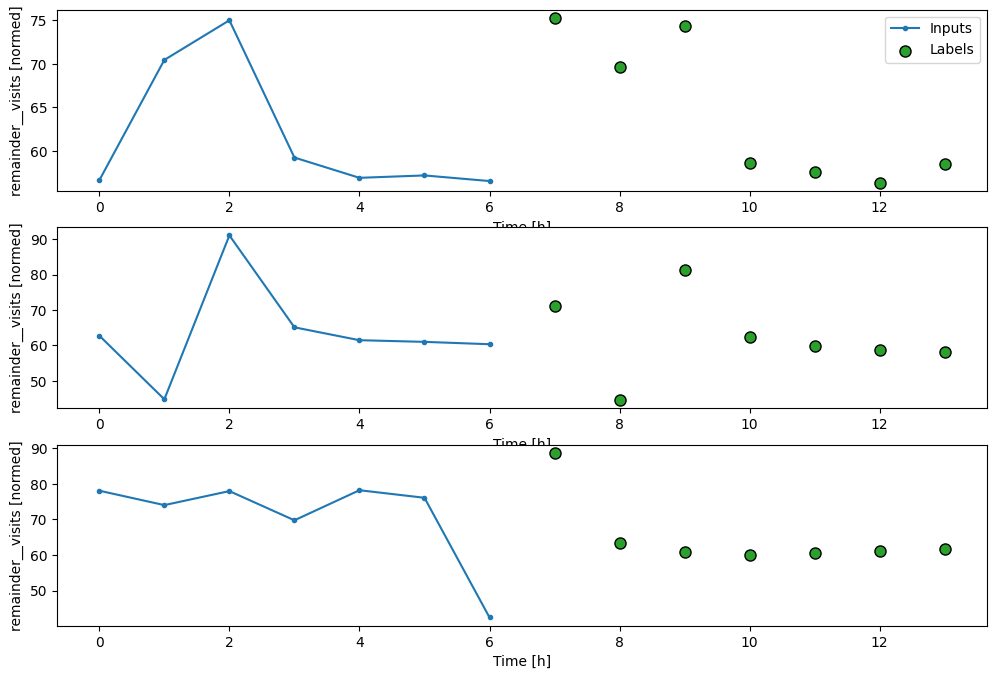

In [10]:
multi_window.plot()

8/8 [==============================] - 0s 2ms/step - loss: 23.3517 - mean_absolute_error: 1.0510


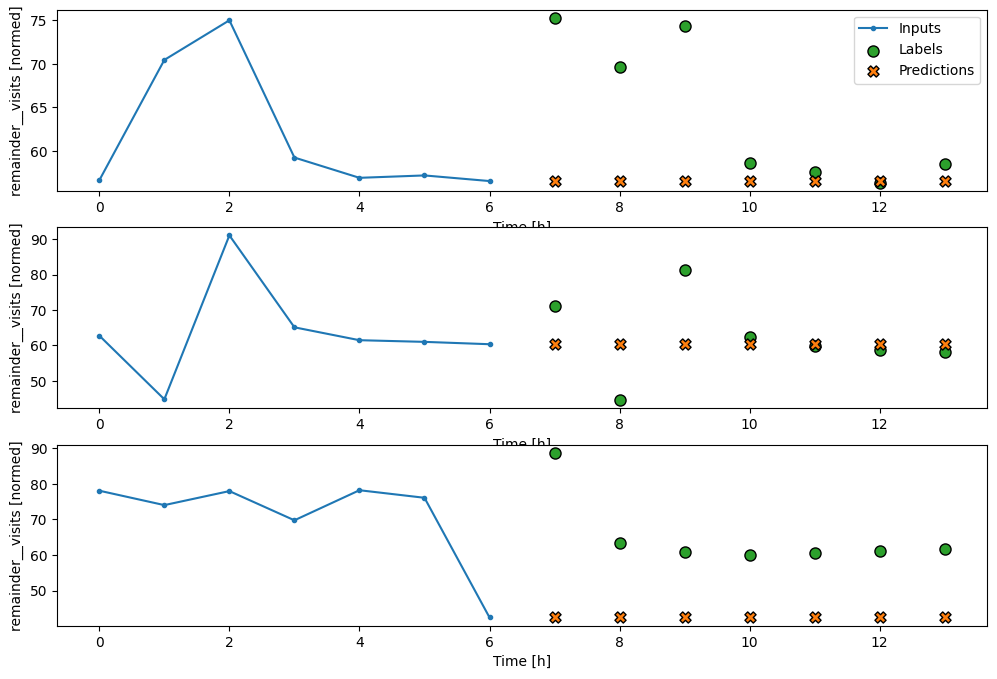

In [11]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)


8/8 [==============================] - 0s 2ms/step - loss: 9.2174 - mean_absolute_error: 0.4131


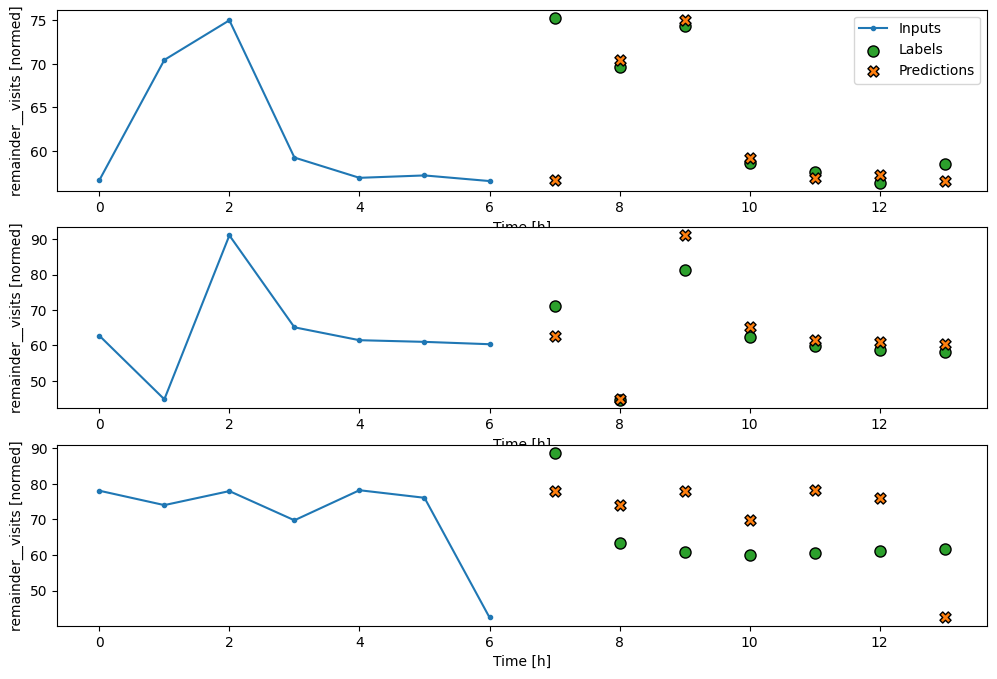

In [12]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)


In [13]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
    validation_data=window.val,
    callbacks=[early_stopping])
  return history


In [20]:
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)


Epoch 1/20


ValueError: in user code:

    File "c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\keras\layers\reshaping\reshape.py", line 118, in _fix_unknown_dimension
        raise ValueError(msg)

    ValueError: Exception encountered when calling layer "reshape_5" "                 f"(type Reshape).
    
    total size of new array must be unchanged, input_shape = [7, 63], output_shape = [7, 9]
    
    Call arguments received by layer "reshape_5" "                 f"(type Reshape):
      • inputs=tf.Tensor(shape=(None, 7, 63), dtype=float32)


In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                    training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions
    
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

